## Setup

Import necessary modules and dependencies. Note that you'll be using <a href="https://seaborn.pydata.org/" class="external">seaborn</a> for visualization in this tutorial.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV (Waveform) audio file format</a> of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [2]:
%cd Project\ spectro

[Errno 2] No such file or directory: 'Project spectro'
/home/utente/Scrivania/Uni/HDA/project/Project spectro


In [3]:
DATASET_PATH = 'full_dataset/'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
mask = np.logical_and(commands != '.DS_Store', commands !='.ipynb_checkpoints')
commands = commands[mask]
print('Commands:', commands)

Commands: ['cat' 'five' 'bird' 'left' 'follow' 'six' 'bed' 'go' 'learn' 'eight'
 'four' 'happy' 'house' 'off' 'dog' 'stop' 'up' 'wow' 'one' 'on' 'sheila'
 'backward' 'no' 'yes' 'seven' 'forward' 'two' 'nine' 'down' 'tree'
 'right' 'visual' 'three' 'zero' 'marvin']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

2022-05-22 15:38:17.317819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Number of total examples: 52500
Number of examples per label: 1500


2022-05-22 15:38:17.363128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 15:38:17.363547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-22 15:38:17.364548: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-22 15:38:17.365075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Split `filenames` into training, validation and test sets using a 70:20:10 ratio, respectively:

In [6]:
train_files = filenames[:int(num_samples*0.7)]
val_files = filenames[int(num_samples*0.7):int(num_samples*0.7)+int(num_samples*0.2)]
test_files = filenames[-int(num_samples*0.1):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 36750
Validation set size 10500
Test set size 5250


## Read the audio files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represents the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> of the audio signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, like the WAV files in the mini Speech Commands dataset, the amplitude values range from -32,768 to 32,767.
- The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for this dataset is 16kHz.

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, where `channels` is `1` for mono or `2` for stereo. The mini Speech Commands dataset only contains mono recordings. 

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [7]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [8]:
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
    return parts[-2]


Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [9]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Let's plot a few audio waveforms:

2022-05-22 15:38:18.506798: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


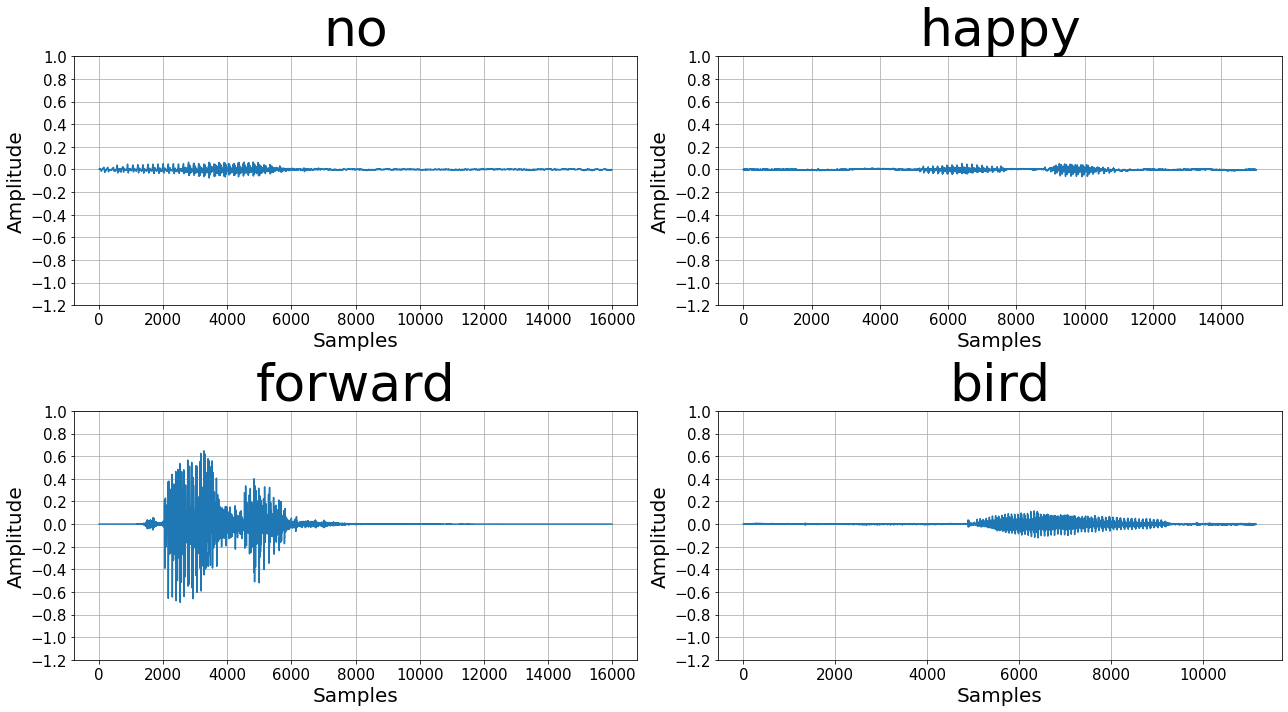

In [11]:
rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_ylabel("Amplitude", fontsize=20)
    ax.set_xlabel("Samples", fontsize=20)
    ax.set_title(label, fontsize=52)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)



    ax.grid()
fig.tight_layout()
plt.savefig("2_example.pdf")

plt.show()


## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">this Coursera video</a> on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [12]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [13]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [14]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
      assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

/tmp/ipykernel_3619/535791129.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


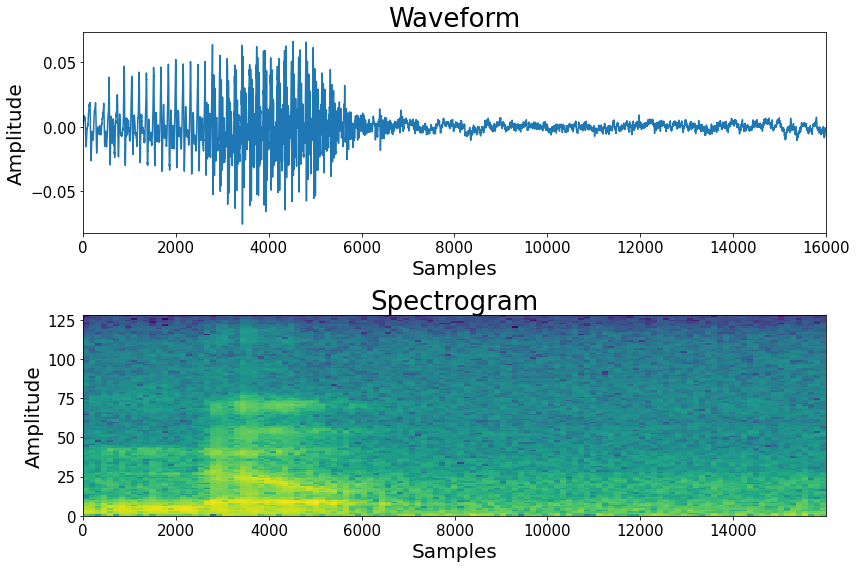

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform',fontsize=26)
axes[0].set_xlim([0, 16000])
axes[0].set_ylabel("Amplitude", fontsize=20)
axes[0].set_xlabel("Samples", fontsize=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram',fontsize=26)
axes[1].set_ylabel("Amplitude", fontsize=20)
axes[1].set_xlabel("Samples", fontsize=20)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)
fig.tight_layout()

plt.savefig("report.pdf")
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [16]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [17]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

/tmp/ipykernel_3619/535791129.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


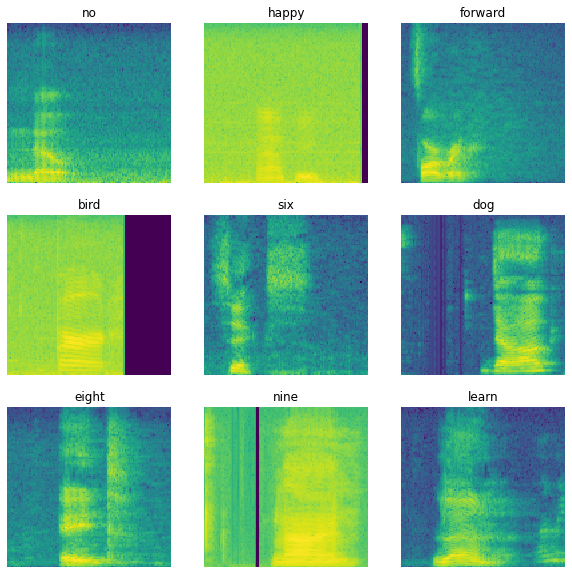

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [19]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [20]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [21]:
for i,_ in train_ds.take(10):
    print(i.numpy().max())

2.0180862
2.559876
17.940916
2.561523
17.861744
9.395137
19.256369
7.6829944
27.884789
6.5985265


Normalizing the 2D image respect to the max value

In [22]:
train_ds = train_ds.map(lambda x,y: (x/tf.reduce_max(x),y),num_parallel_calls=AUTOTUNE) 
val_ds = val_ds.map(lambda x,y: (x/tf.reduce_max(x),y),num_parallel_calls=AUTOTUNE) 
test_ds = test_ds.map(lambda x,y: (x/tf.reduce_max(x),y),num_parallel_calls=AUTOTUNE) 


In [23]:
for i,j in train_ds.take(10):
    print(i.numpy().max())
    print(j,"\n")

1.0
tf.Tensor(22, shape=(), dtype=int64) 

1.0
tf.Tensor(11, shape=(), dtype=int64) 

1.0
tf.Tensor(25, shape=(), dtype=int64) 

1.0
tf.Tensor(2, shape=(), dtype=int64) 

1.0
tf.Tensor(5, shape=(), dtype=int64) 

1.0
tf.Tensor(14, shape=(), dtype=int64) 

1.0
tf.Tensor(9, shape=(), dtype=int64) 

1.0
tf.Tensor(27, shape=(), dtype=int64) 

1.0
tf.Tensor(8, shape=(), dtype=int64) 

1.0
tf.Tensor(0, shape=(), dtype=int64) 



Batch the training and validation sets for model training:

In [24]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [25]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [26]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 129, 1)


In [27]:


# Instantiate the `tf.keras.layers.Normalization` layer.

# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(100, 100),
    layers.Conv2D(16, 2, activation='tanh'),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(32, 2, activation='tanh'),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(64, 2, activation='tanh'),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(128, 2, activation='tanh'),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(256, 2, activation='tanh'),
    layers.MaxPooling2D(pool_size=2),


    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(300, activation='tanh'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 99, 99, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [29]:
EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
    #callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss',verbose=1, patience=2),
)
#Patience:Number of epochs with no improvement after which training will be stopped.
# il parametro che viene monitorato è la loss

Epoch 1/50


2022-05-20 12:11:12.909299: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2022-05-20 12:11:13.662866: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-20 12:11:13.664538: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-20 12:11:13.664580: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-20 12:11:13.665170: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-20 12:11:13.665248: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


575/575 [==============================] - 33s 53ms/step - loss: 2.3212 - accuracy: 0.3364 - val_loss: 1.2732 - val_accuracy: 0.6461
Epoch 2/50
575/575 [==============================] - 16s 28ms/step - loss: 1.2537 - accuracy: 0.6312 - val_loss: 0.8713 - val_accuracy: 0.7525
Epoch 3/50
575/575 [==============================] - 16s 29ms/step - loss: 0.9564 - accuracy: 0.7149 - val_loss: 0.7340 - val_accuracy: 0.7818
Epoch 4/50
575/575 [==============================] - 16s 29ms/step - loss: 0.8345 - accuracy: 0.7546 - val_loss: 0.6521 - val_accuracy: 0.8089
Epoch 5/50
575/575 [==============================] - 16s 29ms/step - loss: 0.7384 - accuracy: 0.7805 - val_loss: 0.6130 - val_accuracy: 0.8230
Epoch 6/50
575/575 [==============================] - 16s 29ms/step - loss: 0.6684 - accuracy: 0.7997 - val_loss: 0.6146 - val_accuracy: 0.8247
Epoch 7/50
575/575 [==============================] - 16s 29ms/step - loss: 0.6221 - accuracy: 0.8158 - val_loss: 0.5385 - val_accuracy: 0.8429
Epo

Let's plot the training and validation loss curves to check how your model has improved during training:

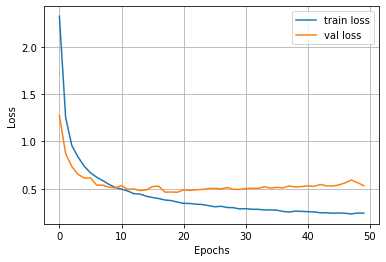

In [30]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig('loss2.png')
plt.show()

In [33]:
import pandas as pd

In [34]:
d = {'train': history.history['loss'], 'val_loss': history.history['val_loss']}
df = pd.DataFrame(data=d)
df.to_csv('cnn_model_report/4loss.csv',index=False)

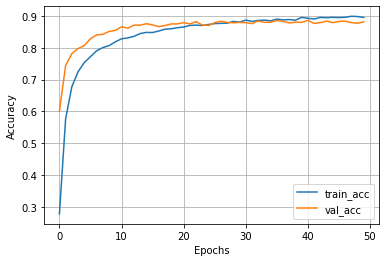

In [31]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.savefig('acc2.png')
plt.show()


In [35]:
d = {'train_acc': history.history['accuracy'], 'val_acc': history.history['val_accuracy']}
df = pd.DataFrame(data=d)
df.to_csv('cnn_model_report/4acc.csv',index=False)

In [36]:
model.save('cnn_model_report/4cnn.h5')

In [27]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('cnn_model_report/2cnn.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_8 (Resizing)        (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 99, 99, 16)        80        
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 48, 48, 32)        2080      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 23, 23, 64)        8256      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 11, 11, 64)       

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [28]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [29]:
model=new_model

In [30]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

2022-05-22 15:38:44.161413: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 335916000 exceeds 10% of free system memory.
2022-05-22 15:38:44.419628: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 335916000 exceeds 10% of free system memory.
2022-05-22 15:38:45.502301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302
2022-05-22 15:38:46.374433: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 15:38:46.375429: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 15:38:46.375461: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-05-22 15:38:46.375986: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-22 15:38:46.376075: W

Test set accuracy: 94%


In [31]:
from sklearn.metrics import confusion_matrix,classification_report
print("\n")
print("\n")
print(classification_report(y_true,y_pred))





              precision    recall  f1-score   support

           0       0.92      0.97      0.95       170
           1       0.99      0.96      0.97       157
           2       0.95      0.90      0.93       155
           3       0.96      0.94      0.95       149
           4       0.93      0.90      0.91       154
           5       0.99      0.96      0.98       144
           6       0.98      0.89      0.93       161
           7       0.93      0.84      0.88       151
           8       0.88      0.95      0.91       154
           9       0.99      0.96      0.98       142
          10       0.93      0.90      0.91       140
          11       0.90      0.97      0.93       163
          12       0.96      0.97      0.96       154
          13       0.94      0.92      0.93       147
          14       0.91      0.88      0.89       155
          15       0.98      0.93      0.95       143
          16       0.92      0.97      0.95       142
          17       0.95

In [ ]:

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       150
           1       0.98      0.96      0.97       157
           2       0.96      0.88      0.92       151
           3       0.99      0.86      0.92       155
           4       0.89      0.91      0.90       127
           5       0.97      0.99      0.98       157
           6       0.98      0.91      0.94       160
           7       0.95      0.87      0.91       149
           8       0.79      0.97      0.87       147
           9       1.00      0.93      0.97       138
          10       0.95      0.90      0.93       156
          11       0.90      0.96      0.93       136
          12       0.96      0.94      0.95       140
          13       0.97      0.93      0.95       162
          14       0.96      0.93      0.94       155
          15       0.98      0.95      0.96       170
          16       0.88      0.96      0.92       132
          17       0.97      0.95      0.96       129
          18       0.97      0.98      0.97       165
          19       0.93      0.95      0.94       150
          20       0.98      0.98      0.98       148
          21       0.99      0.93      0.96       152
          22       0.86      0.97      0.92       157
          23       0.94      0.99      0.97       146
          24       0.97      0.98      0.98       153
          25       0.91      0.90      0.91       167
          26       0.98      0.93      0.96       166
          27       0.94      0.91      0.93       150
          28       0.96      0.96      0.96       160
          29       0.94      0.87      0.91       154
          30       0.96      0.95      0.96       149
          31       0.92      0.94      0.93       140
          32       0.87      0.95      0.91       137
          33       0.95      0.99      0.97       139
          34       0.92      0.97      0.94       146

In [ ]:
df = pandas.DataFrame(report).transpose()


In [32]:
import pandas 
report = classification_report(y_true, y_pred, output_dict=True)
df = pandas.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.900621,0.966667,0.932476,150.000000
1,0.980392,0.955414,0.967742,157.000000
2,0.956835,0.880795,0.917241,151.000000
3,0.985294,0.864516,0.920962,155.000000
4,0.892308,0.913386,0.902724,127.000000
5,0.968944,0.993631,0.981132,157.000000
6,0.979730,0.906250,0.941558,160.000000
7,0.948529,0.865772,0.905263,149.000000
8,0.793296,0.965986,0.871166,147.000000
9,1.000000,0.934783,0.966292,138.000000


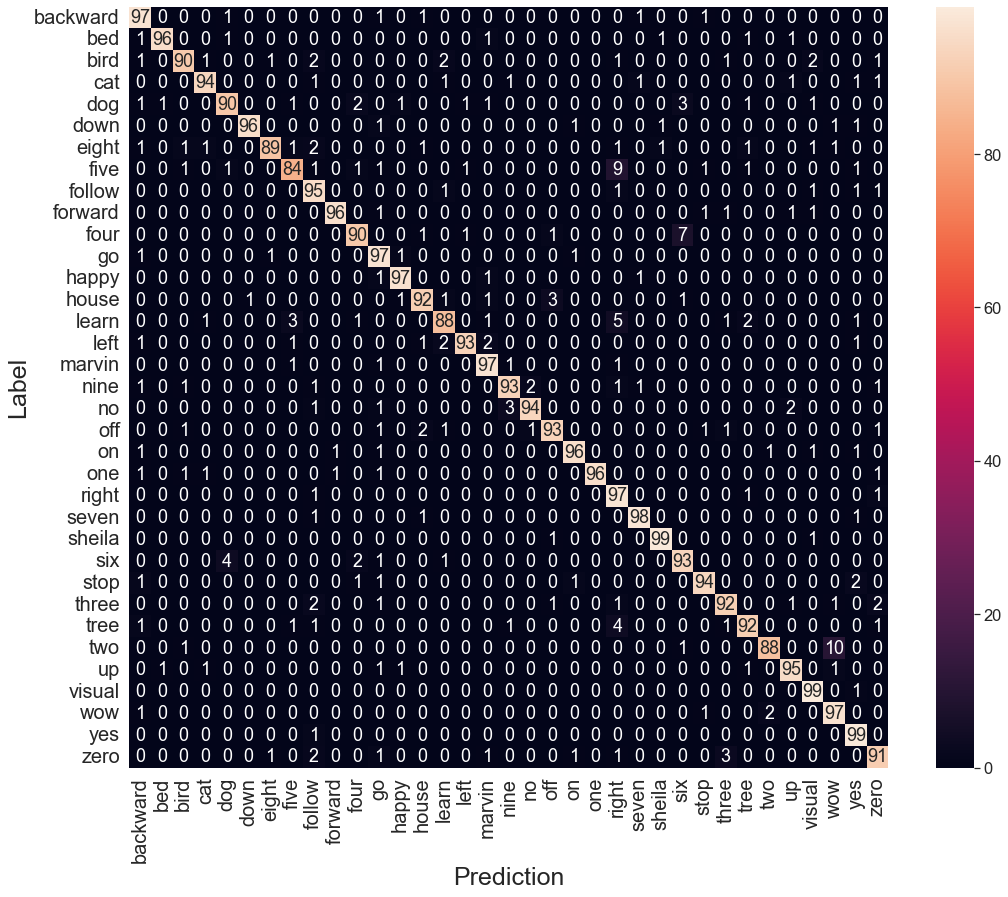

In [50]:
from sklearn.metrics import confusion_matrix

commands = ['backward','bed','bird','cat','dog','down','eight','five','follow',
 'forward','four','go','happy','house','learn','left','marvin',
 'nine', 'no', 'off', 'on', 'one', 'right', 'seven','sheila','six','stop',
 'three', 'tree', 'two', 'up', 'visual','wow','yes','zero']

confusion_matrix=confusion_matrix(y_true, y_pred)
confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]*100
plt.figure(figsize=(17, 14))
sns.set(font_scale=1.5)

res=sns.heatmap(confusion_matrix,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='.0f')
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 20)

res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 20, rotation=90)
plt.xlabel('Prediction', fontsize=25)
plt.ylabel('Label', fontsize=25)
plt.savefig('conf.png')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [34]:
fig, axes = plt.subplots(1,1, figsize=(15, 5))

axes[0].plot(acc['train_acc'], label='train_acc')
axes[0].plot(acc['val_acc'], label='val_acc')
axes[0].set_ylabel("Accuracy", fontsize=20)
axes[0].set_xlabel("Epochs", fontsize=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].legend(fontsize=15)
axes[0].grid()

#fig.suptitle('Simple CNN', fontsize=26)
fig.tight_layout()

plt.savefig("acc+loss_cnn.pdf")
plt.show()

'/home/utente/Scrivania/Uni/HDA/project/Project spectro'

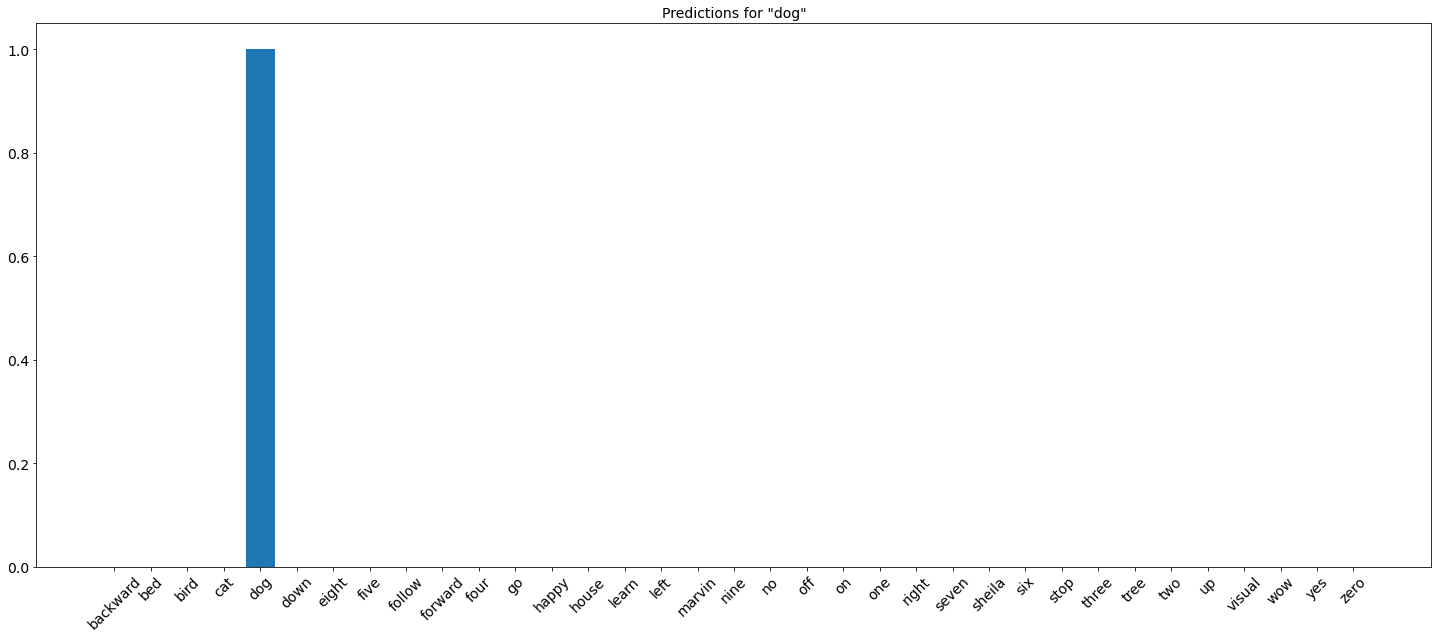

In [35]:
sample_file = data_dir/"follow/017c4098_nohash_0.wav"
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    prediction=np.array(prediction)
    prediction=np.reshape(prediction, len(commands))
    prediction=tf.nn.softmax(prediction)

    
    plt.figure(figsize=(25,10))
    plt.bar(commands, prediction)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    plt.title(f'Predictions for "{commands[np.argmax(prediction)]}"', fontsize=14)
    
    plt.show()

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from <a href="https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview" class="external">Kaggle's TensorFlow speech recognition challenge</a>.
- The 
<a href="https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0" class="external">TensorFlow.js - Audio recognition using transfer learning codelab</a> teaches how to build your own interactive web app for audio classification.
- <a href="https://arxiv.org/abs/1709.04396" class="external">A tutorial on deep learning for music information retrieval</a> (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the <a href="https://librosa.org/" class="external">librosa</a> library—a Python package for music and audio analysis.